In [33]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
%matplotlib inline
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display

from os import listdir, path
from math import floor

import numpy as np
import random

# set random seeds to aid reproducibility
random.seed(22)
np.random.seed(22)
from skimage import io, color
from skimage.transform import resize

In [34]:
malaria_dataset_path = '/Users/sakshigupta/Downloads/cell_images'
parasitized_dir = 'Parasitized'
uninfected_dir = 'Uninfected'
default_ext = '.npy'

def initialize_progress_bar(max_count):
    '''
        Initializes a progress bar with range from
        0 to max_count and returns it.
        
        By setting the value of the progress bar
        returned one can visualise the progress of 
        lengthy processes.
    '''
    
    f = IntProgress(min=0, max=max_count)
    display(f)
    f.value = 0
    return f

def save_data(data, save_file_path, data_type='float32'):
    '''
        Convert the contents of the numpy array specified 
        in data to the data type specified in data_type, 
        by default float32, and then save to disk in the 
        path specified in save_file_path.
    '''
    
    print('Saving file {0}...'.format(save_file_path))
    data = data.astype(data_type)
    np.save(save_file_path, data, allow_pickle=False, fix_imports=False)
    print('Done.')
    return data

def load_data(file_path):
    '''
        Load a numpy array from the file located at 
        file_path and return it.
    '''
    
    data = np.load(file_path)
    return data


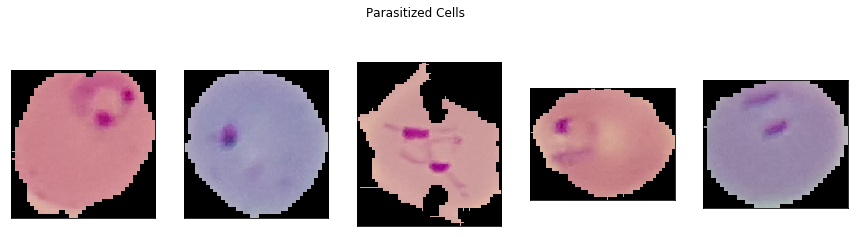

In [35]:
def show_sample_cells(cell_type, num_cells=5, greyscale=False, resize_image=False):
    fig, axes = plt.subplots(1, num_cells, figsize=(15,4))
    fig.suptitle('{0} Cells{1}{2}'.format(cell_type, 
                                          ' - Greyscale' if greyscale else '',
                                          ' - 50x50' if resize_image else ''))
    for idx, f in enumerate(listdir(path.join(malaria_dataset_path, cell_type))[:5]):
        cell_image = io.imread(path.join(malaria_dataset_path, cell_type, f))
        if resize_image:
            cell_image = resize(cell_image, (50, 50, cell_image.shape[2]), mode='reflect')
        if greyscale:
            cell_image = color.rgb2grey(cell_image)
            axes[idx].imshow(cell_image, cmap='gray')
        else:
            axes[idx].imshow(cell_image)
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        
show_sample_cells(parasitized_dir)

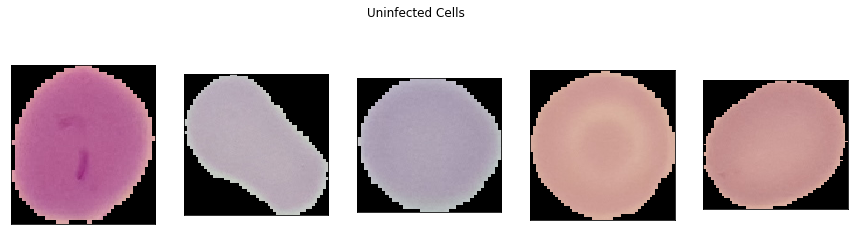

In [36]:
show_sample_cells(uninfected_dir)

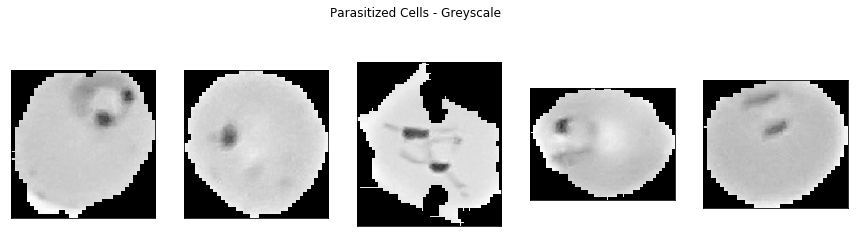

In [37]:
show_sample_cells(parasitized_dir, greyscale=True)

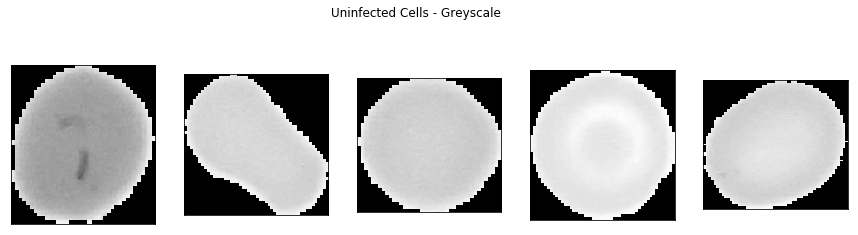

In [38]:
show_sample_cells(uninfected_dir, greyscale=True)

/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

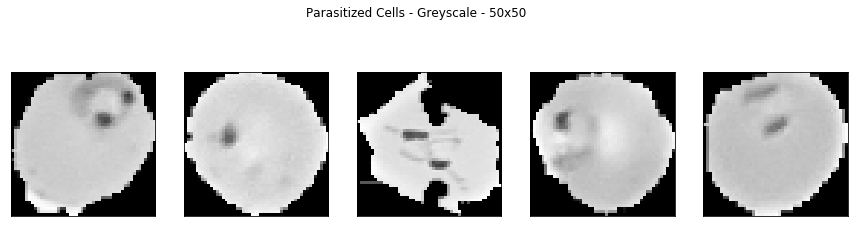

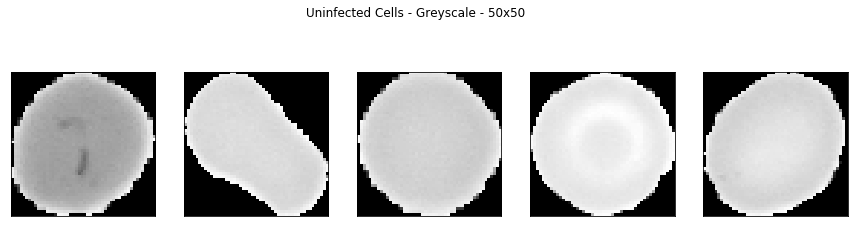

In [39]:
show_sample_cells(parasitized_dir, greyscale=True, resize_image=True)
show_sample_cells(uninfected_dir, greyscale=True, resize_image=True)

In [40]:
def resize_cell_images(cell_images_path):
    cell_image_files = listdir(cell_images_path)
    cell_image_files = [f for f in cell_image_files if f.endswith('.png')]
    cell_image_files.sort()
    
    num_cell_images = len(cell_image_files)
    f = initialize_progress_bar(num_cell_images)
    data = np.zeros((num_cell_images,50,50,3))
    for idx, cell_image_file in enumerate(cell_image_files):
        cell_image = io.imread(path.join(cell_images_path, cell_image_file))
        cell_image_resized = resize(cell_image, (50, 50, cell_image.shape[2]), mode='reflect')
        data[idx] = cell_image_resized
        f.value += 1
    data = data.astype('float32')
    return data

def greyscale_cell_images(data):
    f = initialize_progress_bar(data.shape[0])
    gs_data = np.zeros((data.shape[0],50,50))
    for idx, cell_image in enumerate(data):
        gs_data[idx] = color.rgb2grey(cell_image)
        f.value += 1
    gs_data = gs_data.astype('float32')
    return gs_data

def histnorm_cell_images(data):
    f = initialize_progress_bar(data.shape[0])
    hn_data = np.zeros((data.shape[0],10))
    for idx, cell_image in enumerate(data):
        # range starts from 0.1 to eliminate all black background, value 0
        counts, bins = np.histogram(cell_image, bins=10, range=(0.1,1))
        hn_data[idx] = counts / np.sum(counts)
        f.value += 1
    hn_data = hn_data.astype('float32')
    return hn_data

def load_histnorm_data(cell_types):    
    print('Loading {0}...'.format(cell_types))
    
    histnorm_data_file_path = path.join(malaria_dataset_path, ''.join(['hn_', cell_types, default_ext]))
    if path.isfile(histnorm_data_file_path):
        print('Loading histnorm data...')
        histnorm_data = load_data(histnorm_data_file_path)
    else:
        greyscaled_cell_images_data_file_path = path.join(malaria_dataset_path, ''.join(['gs_', cell_types, default_ext]))
        if path.isfile(greyscaled_cell_images_data_file_path):
            print('Loading greyscaled cell images...')
            greyscaled_cell_images_data = load_data(greyscaled_cell_images_data_file_path)
        else:
            resized_cell_images_data_file_path = path.join(malaria_dataset_path, ''.join(['rs_', cell_types, default_ext]))
            if path.isfile(resized_cell_images_data_file_path):
                print('Loading resized cell images...')
                resized_cell_images_data = load_data(resized_cell_images_data_file_path)
            else:
                print('Resizing cell images...')
                resized_cell_images_data = resize_cell_images(path.join(malaria_dataset_path, cell_types))
                resized_cell_images_data = save_data(resized_cell_images_data, resized_cell_images_data_file_path)
                
            print('Greyscaling cell images...')
            greyscaled_cell_images_data = greyscale_cell_images(resized_cell_images_data)
            greyscaled_cell_images_data = save_data(greyscaled_cell_images_data, greyscaled_cell_images_data_file_path)
            
        print('Histnorming cell images...')
        histnorm_data = histnorm_cell_images(greyscaled_cell_images_data)
        histnorm_data = save_data(histnorm_data, histnorm_data_file_path)
        
    return histnorm_data

In [41]:

def plot_data_scatter(parasitized_data, uninfected_data):
    if (
         parasitized_data.shape[1] >= 2 and
         uninfected_data.shape[1] >= 2
       ):
        # plot top two components
        plt.scatter(parasitized_data[:,0],
                    parasitized_data[:,1],
                    color='navy',
                    alpha=0.5,
                    label='Parasitized')
        plt.scatter(uninfected_data[:,0],
                    uninfected_data[:,1],
                    color='darkorange',
                    alpha=0.5,
                    label='Uninfected')
        plt.legend()

    if (
         parasitized_data.shape[1] >= 3 and
         uninfected_data.shape[1] >= 3
       ):
        # plot top three components
        fig = plt.figure(figsize=(9,5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(parasitized_data[:,0],
                   parasitized_data[:,1],
                   parasitized_data[:,2],
                   color='navy',
                   alpha=0.5,
                   label='Parasitized')
        ax.scatter(uninfected_data[:,0],
                   uninfected_data[:,1],
                   uninfected_data[:,2],
                   color='darkorange',
                   alpha=0.5,
                   label='Uninfected')
        ax.legend()
        
    plt.show()

Loading Parasitized...
Loading histnorm data...
Loading Uninfected...
Loading histnorm data...


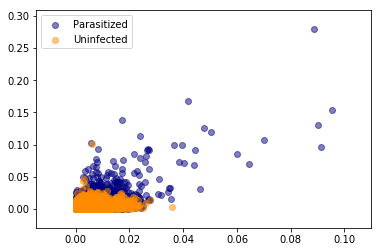

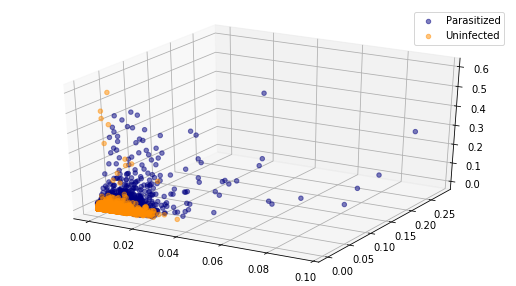

In [42]:
parasitized_histnorm_data = load_histnorm_data(parasitized_dir)
uninfected_histnorm_data = load_histnorm_data(uninfected_dir)
plot_data_scatter(parasitized_histnorm_data, uninfected_histnorm_data)

In [158]:

def _add_class(data, positive_class=False):    
    if positive_class:
        new_data = np.ones((data.shape[0], data.shape[1]+1))
    else:
        new_data = np.zeros((data.shape[0], data.shape[1]+1))
    new_data[:,:-1] = data[:,:]
    return new_data

def _create_training_testing_split(parasitized_class_data, uninfected_class_data, training=0.8):
    '''
        training: default to 80% of data
        testing: remaining data
    '''
    
    # equal count of parasitized and uninfected records in the malaria dataset
    assert parasitized_class_data.shape[0] == uninfected_class_data.shape[0]
    
    num_samples_in_each_class = parasitized_class_data.shape[0]
    num_features_plus_class = parasitized_class_data.shape[1]
    
    print('{0} samples in each class with {1} features.'.format(num_samples_in_each_class,
                                                                num_features_plus_class-1))
    
    training_count = floor(num_samples_in_each_class * training)
    testing_count = num_samples_in_each_class - training_count
    
    print('Splitting into {0} training and {1} testing samples.'.format(training_count,
                                                                        testing_count))
    
    # Create random training / testing index masks for parasitized / uninfected data
    # so as to split data randomly into training and testing sets.
    parasitized_testing_indices = random.sample(range(0, num_samples_in_each_class), testing_count)
    parasitized_training_mask = np.ones(num_samples_in_each_class, dtype=bool)
    parasitized_training_mask[parasitized_testing_indices] = False
    uninfected_testing_indices = random.sample(range(0, num_samples_in_each_class), testing_count)
    uninfected_training_mask = np.ones(num_samples_in_each_class, dtype=bool)
    uninfected_training_mask[uninfected_testing_indices] = False
    
    # creating training data set
    training_data = np.zeros((training_count*2, num_features_plus_class))
    training_data[:training_count,:] = parasitized_class_data[parasitized_training_mask]
    training_data[training_count:,:] = uninfected_class_data[uninfected_training_mask]
    
    testing_data = np.zeros((testing_count*2, num_features_plus_class))
    testing_data[:testing_count,:] = parasitized_class_data[~parasitized_training_mask]
    testing_data[testing_count:,:] = uninfected_class_data[~uninfected_training_mask]
    
    # shuffle rows
    np.random.shuffle(training_data)
    np.random.shuffle(testing_data)
    
    return training_data, testing_data

def _create_training_testing_data():
    print('Creating training and testing data files...')
        
    print('Loading histnormed data...')
    parasitized_histnorm_data = load_histnorm_data(parasitized_dir)
    uninfected_histnorm_data = load_histnorm_data(uninfected_dir)

    print('Extracting features from data...')
    parasitized_class_data = _add_class(parasitized_histnorm_data, positive_class=True)
    uninfected_class_data = _add_class(uninfected_histnorm_data)

    print('Splitting data into training and testing data sets...')
    training_data, testing_data = _create_training_testing_split(parasitized_class_data,
                                                                 uninfected_class_data)
    
    assert np.sum(training_data[:,-1:]) == len(training_data)/2, "Training data is not balanced."
    assert np.sum(testing_data[:,-1:]) == len(testing_data)/2, "Testing data is not balanced."
    
    print('Done.')
    
    return training_data, testing_data
    
def load_datasets():
    training_file_path = path.join(malaria_dataset_path, ''.join(['training', default_ext]))
    testing_file_path = path.join(malaria_dataset_path, ''.join(['testing', default_ext]))
    
    if path.isfile(training_file_path) and path.isfile(testing_file_path):
        print('Loading training and testing data...')
        training_data = load_data(training_file_path)
        testing_data = load_data(testing_file_path)
        print('Done.')
    else:
        training_data, testing_data = _create_training_testing_data()
        
        print('Saving training and testing data sets...')
        training_data = save_data(training_data, training_file_path)
        testing_data = save_data(testing_data, testing_file_path)
        print('Done.')
        
    X_train = training_data[:,-1:]
    y_train = training_data[:,-1:]
    #y_train = y_train.reshape([y_train.shape[0],])
    X_test = testing_data[:,-1:]
    y_test = testing_data[:,-1:]
    #y_test = y_test.reshape([y_test.shape[0],])
        
    return X_train, y_train, X_test, y_test

In [159]:
X_train, y_train, X_test, y_test = load_datasets()

Loading training and testing data...
Done.


In [160]:
len(X_train)

22046

In [161]:
len(y_train)

22046

In [162]:
len(X_test)

5512

In [191]:
len(y_test)

5512

In [192]:
#img_rows=50 #dimensions of image for the custom CNN
#img_cols=50
channel = 3 #RGB
number_of_classes = 2 #binary classification
#batch_size = 32 # modify based on the GPUs in your system
#num_epoch = 300 # modify depending on the model convergence with your data#print the shape of the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1, 1, 22046, 1) (22046, 1)
(5512, 1) (5512, 1)


In [194]:
#model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(50,50,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

#fix the optimizer
sgd = SGD(lr=1e-6, decay=1e-6, momentum=0.9, nesterov=True) #try varying this for your task and see the best fit

#compile the model
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
activation_27 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_28 (Activation)   (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 9, 9, 64)          18496     
__________

In [195]:
#X_train = np.expand_dims(X_train, axis=1)
hist = model.fit(X_train,y_train,batch_size=512,epochs=20)

ValueError: Error when checking input: expected conv2d_61_input to have shape (50, 50, 3) but got array with shape (1, 22046, 1)

In [183]:
print(model.evaluate(X_test, y_test))

ValueError: Error when checking input: expected conv2d_53_input to have 4 dimensions, but got array with shape (5512, 1)